* <h1><center><font size="6">CNN with Keras for Fashion MNIST</font></center></h1>


<img src="https://kaggle2.blob.core.windows.net/datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-card.png" width="400"></img>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read and prepare the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Prepare the model</a>  
- <a href='#6'>Prediction accuracy</a>   
    - <a href='#61'>Correctly classified images</a>   
    - <a href='#62'>Incorrectly classified images</a>   
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>

# <a id="1">Introduction</a>  


## Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.   

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.   

The training and test data sets have 785 columns.   

The first column consists of the class labels (see above), and represents the article of clothing. 

The rest of 784 columns (1-785) contain the pixel-values of the associated image.

# <a id="2">Load packages</a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters

In [219]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 50
BATCH_SIZE = 128

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="../input/fashionmnist/"
else:
    PATH="../input/"
print(os.listdir(PATH))

['train-images-idx3-ubyte', 'train-labels-idx1-ubyte', 't10k-labels-idx1-ubyte', 'fashion-mnist_train.csv', 't10k-images-idx3-ubyte', 'fashion-mnist_test.csv']


# <a id="3">Read and prepare the data</a>

There are 10 different classes of images, as following: 

* **0**: **T-shirt/top**;   
* **1**: **Trouser**;   
* **2**: **Pullover**;   
* **3**: **Dress**;
* **4**: **Coat**;
* **5**: **Sandal**;
* **6**: **Shirt**;
* **7**: **Sneaker**;
* **8**: **Bag**;
* **9**: **Ankle boot**.

Image dimmensions are **28**x**28**.   

The train set and test set are given in two separate datasets.

We will split the image train set in train and validation set, with the split between the  train and validation of 0.8/0.2 from the original train set.


In [220]:
img_rows, img_cols = IMG_ROWS, IMG_COLS
num_classes = NUM_CLASSES

# data preprocessing
def data_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw.label, num_classes)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

train_file = PATH+"fashion-mnist_train.csv"
test_file  = PATH+"fashion-mnist_test.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# prepare the data
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


# <a id="4">Data exploration</a>

![](http://)The dimmension of the original  train,  test set are as following:

In [221]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


> The dimmension of the processed train, validation and test set are as following:

In [222]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


## <a id="41">Class distribution</a>

Let's see how many number of images are in each class. We start with the train set.

### Train set images class distribution

In [223]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)

Ankle Boot          :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Coat                :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Trouser             :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%


The classes are equaly distributed in the train set (10% each). Let's check the same for the test set.

### Test set images class distribution

In [224]:
get_classes_distribution(test_data)

Sneaker             :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Dress               :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Bag                 :   1000 or 10.0%
T-shirt/top         :   1000 or 10.0%


Also in the test set the 10 classes are equaly distributed (10% each).

## <a id="42">Sample images</a>

### Test set images

Let's plot some samples for the images.

In [225]:
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(28,28)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


Let's now plot the images.

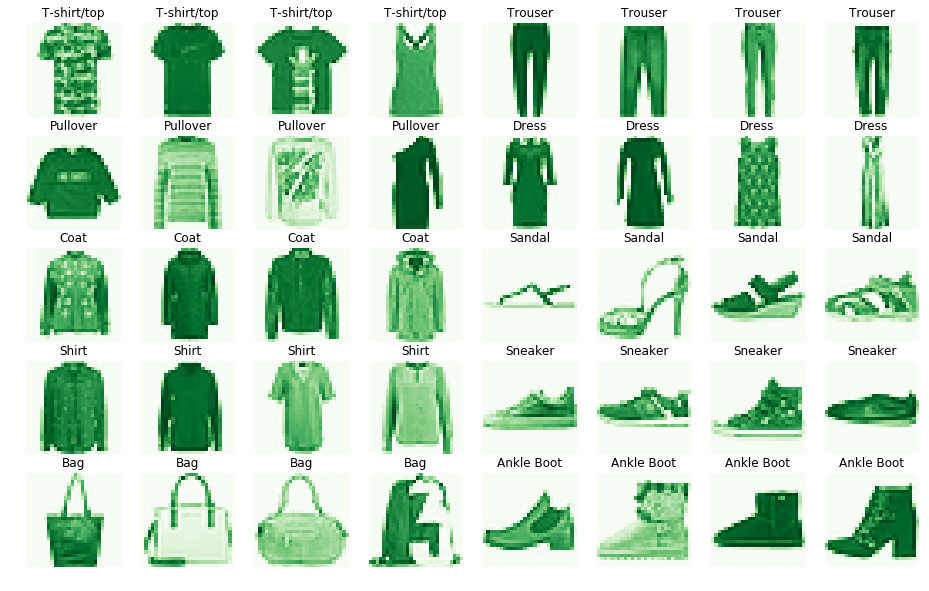

In [226]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
    
plot_sample_images(train_sample_images,train_sample_labels, "Greens")

### Train set images

Let's plot now a selection of the train set images.

Total number of sample images to plot:  40


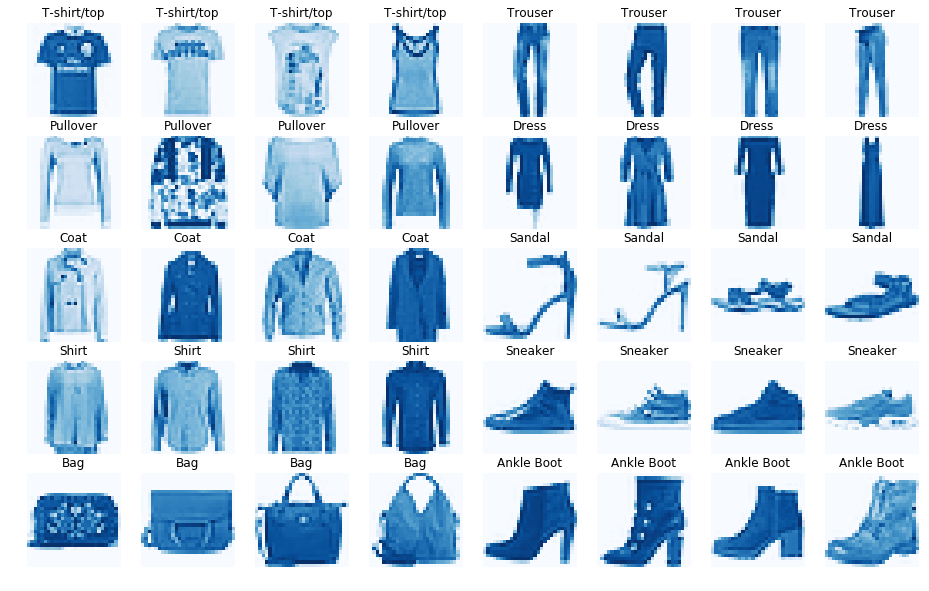

In [227]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels)

# <a id="3">Prepare the model</a>


We will use a **Sequential** model.
* The **Sequential** model is a linear stack of layers. It can be first initialized and then we add layers using **add** method or we can add all layers at init stage. The layers added are as follows:

* **Conv2D** is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:
 * filters - the number of filters (Kernels) used with this layer; here filters = 32;
 * kernel_size - the dimmension of the Kernel: (3 x 3);
 * activation - is the activation function used, in this case `relu`;
 * kernel_initializer - the function used for initializing the kernel;
 * input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28
 The input and output of the **Conv2D** is a 4D tensor.
 
* **MaxPooling2D** is a Max pooling operation for spatial data. Parameters used here are:
 * *pool_size*, in this case (2,2), representing the factors by which to downscale in both directions;
 
* **Dropout**. Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. The parameter used is:
 * *rate*, set here to 0.25. 
 
* **Conv2D** with the following parameters:
 * filters: 64;
 * kernel_size : (3 x 3);
 * activation : `relu`;
 
* **MaxPooling2D** with parameter:
 * *pool_size* : (2,2);

* **Dropout**. with parameter:
 * *rate* : 0.25;
 
* **Conv2D** with the following parameters:
 * filters: 128;
 * kernel_size : (3 x 3);
 * activation : `relu`;

* **Dropout**. with parameter:
 * *rate* : 0.4;
 
* **Flatten**. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

* **Dense**. This layer is a regular fully-connected NN layer. It is used without parameters;
 * units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
 * activation - activation function : `relu`;

* **Dropout**. with parameter:
 * *rate* : 0.3;
 
* **Dense**. This is the final layer (fully connected). It is used with the parameters:
 * units: the number of classes (in our case 10);
 * activation : `softmax`; for this final layer it is used `softmax` activation (standard for multiclass classification)
 

Then we compile the model, specifying as well the following parameters:
* *loss*;
* *optimizer*;
* *metrics*. 


In [228]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

## Show the model

Let's check the model we initialized.

In [229]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)         73856     
__________

## Run the model

We run the model with the training set. We are also using the validation set (a subset from the orginal training set) for validation.

In [230]:
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NO_EPOCHS,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 7s 145us/step - loss: 0.7728 - acc: 0.7084 - val_loss: 0.4753 - val_acc: 0.8316
Epoch 2/50
48000/48000 [==============================] - 6s 127us/step - loss: 0.4807 - acc: 0.8216 - val_loss: 0.3742 - val_acc: 0.8654
Epoch 3/50
48000/48000 [==============================] - 6s 126us/step - loss: 0.4098 - acc: 0.8505 - val_loss: 0.3251 - val_acc: 0.8857
Epoch 4/50
48000/48000 [==============================] - 6s 126us/step - loss: 0.3728 - acc: 0.8658 - val_loss: 0.3099 - val_acc: 0.8900
Epoch 5/50
48000/48000 [==============================] - 6s 126us/step - loss: 0.3455 - acc: 0.8741 - val_loss: 0.2908 - val_acc: 0.8965
Epoch 6/50
48000/48000 [==============================] - 6s 125us/step - loss: 0.3254 - acc: 0.8800 - val_loss: 0.2964 - val_acc: 0.8924
Epoch 7/50
48000/48000 [==============================] - 6s 125us/step - loss: 0.3174 - acc: 0.8846 - val_loss: 0.2715 - 

### Evaluate the model score

We calculate the test loss and accuracy.

In [231]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19960005313158036
Test accuracy: 0.93


Test accuracy is  0.93.

# <a id="6">Prediction accuracy</a>

We evaluate the model accuracy based on the predicted values for the test set.

In [232]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
#get the indices to be plotted
y_true = test_data.iloc[:, 0]

In [233]:
p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [234]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.86      0.91      0.88      1000
    Class 1 (Trouser) :       0.99      0.99      0.99      1000
   Class 2 (Pullover) :       0.88      0.91      0.89      1000
      Class 3 (Dress) :       0.93      0.95      0.94      1000
       Class 4 (Coat) :       0.90      0.89      0.89      1000
     Class 5 (Sandal) :       1.00      0.98      0.99      1000
      Class 6 (Shirt) :       0.82      0.75      0.79      1000
    Class 7 (Sneaker) :       0.96      0.97      0.96      1000
        Class 8 (Bag) :       0.99      0.98      0.98      1000
 Class 9 (Ankle Boot) :       0.97      0.97      0.97      1000

            avg / total       0.93      0.93      0.93     10000




The best accuracy is obtained for Class 1, Class 5, Class 8, Class 9  and Class 7. Worst accuracy is for Class 6.   

The recall is highest for Class 8, Class 5 and smallest for Class 6 and Class 4.    

f1-score is highest for Class 1, Class 5 and Class 8 and smallest for Class 6 followed by Class 4 and Class 2.  

Let's also inspect some of the images. We created two subsets of the predicted images set, correctly and incorrectly classified.


## <a id="61">Correctly classified images</a>


We visualize few images correctly classified.

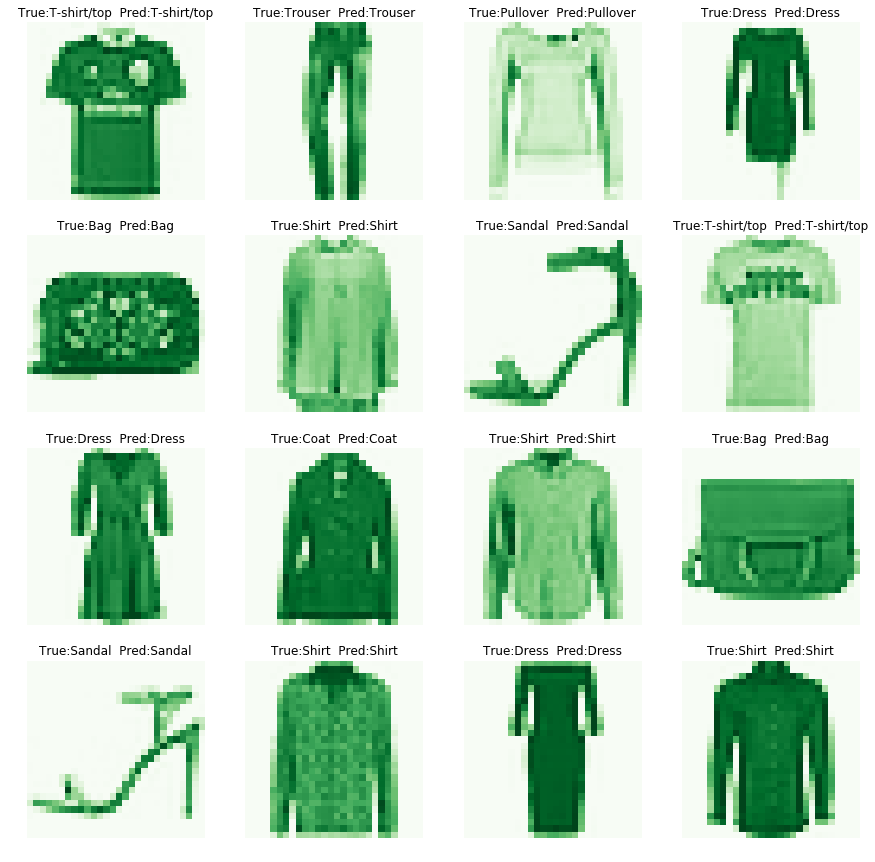

In [235]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(28,28), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, "Greens")

## <a id="62">Incorrectly classified images</a>

Let's see also few images incorrectly classified.

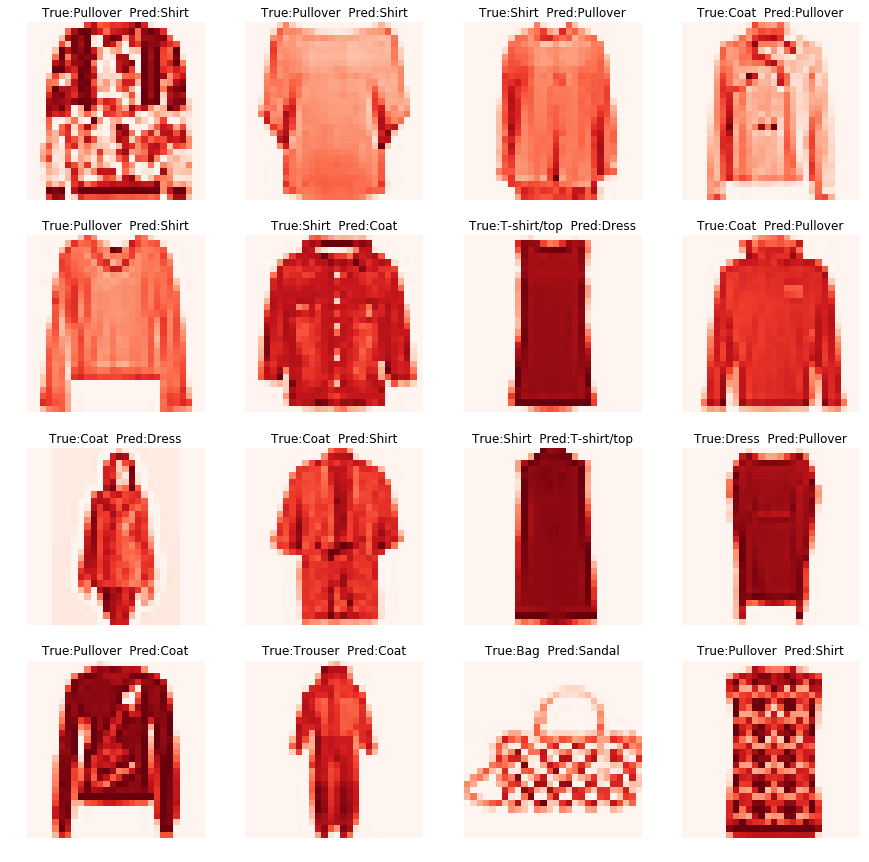

In [217]:
plot_images(incorrect, "Reds")

# <a id="7">Conclusions</a>

With a complex sequential model with multiple convolution layers and 50 epochs for the training, we obtained an accuracy above 0.92. Only few classes are not correctly classified, especially Class 6 (Shirt) and Class 2 (Pullover).

# <a id="8">References</a>

[1] Fashion MNIST, An MNIST-like dataset of 70,000 28x28 labeled fashion images, https://www.kaggle.com/zalando-research/fashionmnist  
[2] DanB, CollinMoris, Deep Learning From Scratch, https://www.kaggle.com/dansbecker/deep-learning-from-scratch  
[3] DanB, Dropout and Strides for Larger Models, https://www.kaggle.com/dansbecker/dropout-and-strides-for-larger-models  
[4] BGO, CNN with Keras, https://www.kaggle.com/bugraokcu/cnn-with-keras    
[5] NAIN, EagerFMINST, https://www.kaggle.com/aakashnain/eagerfmnist
